In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd

# Load data

The data sample contains coordinates and time of photons reqistered in a Kiloton-Scale Liquid Scintillator Detector. There are two classes of events. The signal class contains double beta decay ($\beta\beta$-decay) events. The background class contains events of neutrino interactions due to $^{8}B$ decays in the sun. 

The detector has spherical form and registers photons on its surface. Each event is described by coordinates and time of registered photons. There are two types of photons in an event. Cherenkov photons fly in a cone and are produced by a particle due to Cherenkov effect. Scintillation photons fly in all directions and are produced due to interactions of photons and electrons with scintillator of the detector. 

Example of ideal (without scattering) signal (left) and background (right) events is shown in the following figure:

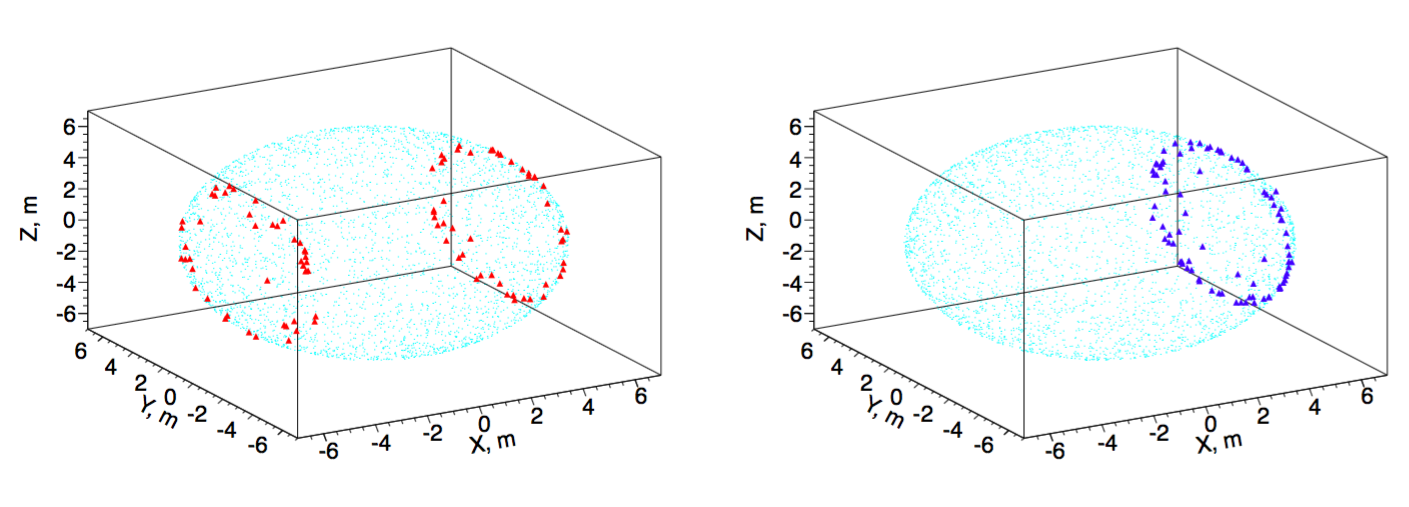

Red and blue triangles correspond to Cherenkov photons, cyan dots - scintillation photons.

In [2]:
data_path = '../kaggle'

data_train = pd.read_csv(data_path+'/data_train.csv.gz')
labels_train = pd.read_csv(data_path+'/labels_train.csv.gz')

In [3]:
data_train.head()

,EventID,Theta,Phi,Time
0,0.0,0.579059,6.127253,1.899265
1,0.0,0.474867,4.257784,0.513214
2,0.0,1.559526,3.268345,1.542545
3,0.0,1.692516,0.335438,1.794285
4,0.0,1.246705,3.829806,2.021858


In [4]:
labels_train.head()

,EventID,Label
0,0.0,1
1,1.0,1
2,3.0,1
3,5.0,1
4,8.0,1


# Create images

For each event create an image in ($\theta$, $\phi$) coordinates with several time channels.

In [5]:
def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    for i_event in event_ids:
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, bins=(n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        
    return np.array(images)

In [6]:
%%time
images = create_images(data_train, 
                       n_theta_bins=10, 
                       n_phi_bins=20, 
                       n_time_bins=6)

CPU times: user 1min 47s, sys: 1.44 s, total: 1min 48s
Wall time: 1min 48s


In [7]:
print('Sample (images, theta, phi, time): ', images.shape)

Sample (images, theta, phi, time):  (80000, 10, 20, 6)


Image example


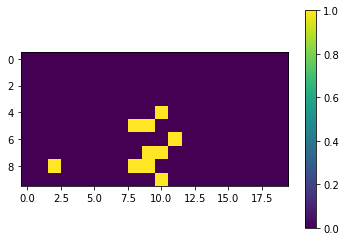

In [8]:
print('Image example')
img = images[100][:, :, 1]
plt.imshow(img)
plt.colorbar()
plt.show()

# Split into training and test samples

In [9]:
from sklearn.model_selection import train_test_split

X = images / 10.
y = labels_train['Label'].values

(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.25)
print('images:', trainX.shape, testX.shape)
print('labels:', trainY.shape, testY.shape)

images: (60000, 10, 20, 6) (20000, 10, 20, 6)
labels: (60000,) (20000,)


# My solution

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
pca.fit(trainX.reshape(len(trainX), -1, ))
trainX_pca = pca.transform(trainX.reshape(len(trainX), -1, ))
testX_pca = pca.transform(testX.reshape(len(testX), -1, ))

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=None)
clf.fit(trainX_pca, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

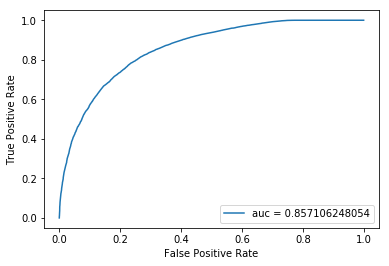

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
predY = clf.predict_proba(testX_pca)[:, 1]
auc = roc_auc_score(testY, predY)
fpr, tpr, thr =roc_curve(testY, predY)
plt.plot(fpr, tpr, label = 'auc = ' + str(auc) )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Create submission file

Make predictions for test data and prepare a submission file.

In [13]:
# Read test data
data_test = pd.read_csv(data_path+'/data_test.csv.gz')

# Create images
images_test = create_images(data_test, 
                            n_theta_bins=10, 
                            n_phi_bins=20, 
                            n_time_bins=6)

# Scale images
X_test = images_test / 10.

In [14]:
X_test_pca = pca.transform(X_test.reshape(len(X_test), -1, ))

In [15]:
submission = pd.DataFrame()
submission['EventID'] = np.unique(data_test['EventID'].values)
submission['Proba'] = clf.predict_proba(X_test_pca)[:, 1]
submission.to_csv('submission.csv.gz', index=False, float_format='%.6f', compression="gzip")